# Machine learning multiclass classification of stars according to their subclass (O, B, A, F, G, K, M, brown dwarfs)

<hr style="border:1px solid gray">

Authors : Marina Koukouvaou
        & Ioannis Mageiras
         
Date :    2021      
<hr style="border:1px solid gray">

### Hertzsprung-Russell Diagram
<hr style="border:1px solid gray">


Temperature (or spectral type) as a function of luminosity of stars. The position of a star in the HR diagram reveals information about its evolutionary stage and its physical properties. In this classification we attend to classify the stellar population into the subclasses shown in the HR diagram, based on their photometry and astrometry.

<img src="hr.jpg"  width="600" height="500">
<hr style="border:1px solid gray">


### Creation of the training dataset
<hr style="border:1px solid gray">

The SDSS DR16 SQL search tool was used to retrieve all the stars for which the photometry in the optical colours was available. The stars are downloaded in groups of different subclasses, which are though uneven in size. This fact is due to physical reasons. The more massive O, B are the rarest to be found and measured, as they stay for shortest time in the main sequence and are quickly led to their death. This is a source of imbalance in our training set, and will be discussed again in what follows.
<hr style="border:1px solid gray">


### SQL query to cross match spectral and photometric catalogues of objects quasars
<hr style="border:1px solid gray">

We qeury the following columns from the spectroscopic catalogue SpecObj:

the equatorial coordinates: ra, dec 

the class (here class=star) and the subclass of the star

the redshift z and its error


and we JOIN this catalogue with the photometric one PhotoObj based on the objID. From PhotoObj we query:

the optical colors that will be features of the training and their corresponding errors:

u 

g

r

i

z

[Link to SDSS DR16 SQL SEARCH](https://skyserver.sdss.org/dr16/en/tools/search/sql.aspx)

### SQL Code used to gather the training dataset

SELECT p.objID, s.ra, s.dec, p.b, p.l, s.class, s.subClass, s.z, s.zErr,  p.u, p.err_u, p.g, p.err_g, p.r, p.err_r, p.i, p.err_i, p.z, p.err_z

FROM photoObj AS p 

JOIN specObj AS s ON s.bestObjID = p.objID

WHERE s.zWarning = 0 AND s.class = 'star'


The catalogue is downloaded as a CSV file, that can easily be manipulated with the pandas package.
<hr style="border:1px solid gray">


## Features:
<hr style="border:1px solid gray">


For the multiclass stellar classification the photometric measurements are used as features of the training, while the dependent variable (truth) is the subClass.

### Enrich the training dataset with more features:

We can extend the photometry so that it includes not only the optical, but also the infrared magnitudes. To achieve that, the initial stars catalogue extracted from the SDSS is cross-matched with infrared surveys such as the UKIDDS and the AllWISE. The stars are identified on the different catalogues based on their equatorial coordinates. For the process the CDS-XMatch online tool is used: 


[Link to CDS-XMATCH SERVICE](https://cdsxmatch.u-strasbg.fr/)

The final set of features inludes, besides the u, g, r, i, z magnitudes, the mid-infrared:

H

Y

J

K

and the far-infrared ones:

W1

W2

W3

W4

A final cross-match with GAIA EDR3 survey is done, providing the astrpmetric measurements for te same astronomical objects, that is their parallaxes, proper motions and the corresponding errors.
<hr style="border:1px solid gray">


### Import the necessary packages:


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import xgboost as xgb
import sklearn as sk
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
import pickle
import warnings
warnings.filterwarnings("ignore")

### Read the CSV file for the stars 

In [3]:
star= pd.read_csv("star_wise_ukidss_gaia.csv", na_values= '#DIV/0!' )

Inspect the 5 first rows of the pandas file with the .head() and all the columns, with the display.max_columns option:

In [4]:
pd.set_option('display.max_columns', None)  #to inspect all the columns of the csv
star.head()

,ra,dec,u,g,r,i,z,subClass,W1mag,W2mag,W3mag,W4mag,y,j,h,k,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,pm_error,pm_over_error,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag
0,188.268404,-1.102205,18.60147,17.29202,16.78694,16.58411,16.46823,F9,15.074,15.216,12.463,8.970,15.881,15.601,15.211,15.093,0.6497,0.0606,10.7197,8.219,-7.812,0.080,-2.555,0.054,0.096519,85.153841,16.797150,17.171358,16.248901
1,188.268404,-1.102205,18.60147,17.29202,16.78694,16.58411,16.46823,F9,15.074,15.216,12.463,8.970,15.898,15.592,15.234,15.136,0.6497,0.0606,10.7197,8.219,-7.812,0.080,-2.555,0.054,0.096519,85.153841,16.797150,17.171358,16.248901
2,188.315335,-1.085287,18.55254,17.59738,17.23129,17.07499,16.99711,F5,15.576,15.459,12.710,8.542,16.441,16.171,15.891,15.789,0.4909,0.0757,6.4849,28.692,-6.177,0.093,-28.019,0.066,0.114039,251.597108,17.205303,17.517904,16.722445
3,188.318872,-1.246636,16.04291,15.10520,14.74819,14.60099,14.53189,F5,13.260,13.283,12.394,8.763,13.910,13.675,13.406,13.341,1.1900,0.0273,43.6180,55.628,-45.802,0.033,-31.570,0.025,0.041400,1343.655819,14.745743,15.041323,14.274858
4,188.338785,-1.214387,18.18184,16.91953,16.51289,16.36012,16.29571,F9,14.998,15.027,12.085,8.778,15.698,15.456,15.164,15.128,0.4679,0.0550,8.5085,11.417,-10.524,0.068,-4.427,0.048,0.083235,137.166501,16.524487,16.857183,16.038565


### Differentiate the different subclasses:
<hr style="border:1px solid gray">


Now we want to divide our data into 9 different subclasses: O, OB, B, A, F, G, K, red dwarfs, brwown drafs. However each subclass has subdivisions, for example there are the F1, F2...F9 subdivisions of the F subclass. We group all these into larger classes by locating the first letter, which in every subdivision of a certain subclass is the same. Excemption to that is the M subclass, which is split into the red and brown dwrafs, and so at first we group all its subdivision separately.
<hr style="border:1px solid gray">


In [5]:
O=star[star["subClass"].str[:1] =="O"]
OB=star[star["subClass"].str[:12] =="OB"]
B=star[star["subClass"].str[:1] =="B"]
A=star[star["subClass"].str[:1] =="A"]
F=star[star["subClass"].str[:1] =="F"]
G=star[star["subClass"].str[:1] =="G"]
K=star[star["subClass"].str[:1] =="K"]
M1=star[star["subClass"].str[:12] =="M1"]
M2=star[star["subClass"].str[:12] =="M2"]
M3=star[star["subClass"].str[:12] =="M3"]
M4=star[star["subClass"].str[:12] =="M4"]
M5=star[star["subClass"].str[:12] =="M5"]
M6=star[star["subClass"].str[:12] =="M6"]
M7=star[star["subClass"].str[:12] =="M7"]
M8=star[star["subClass"].str[:12] =="M8"]
M9=star[star["subClass"].str[:12] =="M9"]
L=star[star["subClass"].str[:1] =="L"]
T=star[star["subClass"].str[:1] =="T"]

<hr style="border:1px solid gray">

In astrophysics, the early type M stars are called red dwarfs. Therefore the red dwarf (RD) subclass is created by the concatenation of the M1, M2, M3 and M4 subdivisions of the M class. In the same manner we create the brown dwarf class (BD), concatenating the L,T and the late M types.
<hr style="border:1px solid gray">


In [6]:
red = pd.concat([M1,M2,M3,M4],axis = 0, ignore_index = True).reset_index(drop = True)
brown = pd.concat([M5,M6,M7,M8, M9,L,T],axis = 0, ignore_index = True).reset_index(drop = True)

In [7]:
O['subclass'] = 'O'
OB['subclass'] = 'OB'
B['subclass'] = 'B'
A['subclass'] = 'A'
F['subclass'] = 'F'
G['subclass'] = 'G'
K['subclass'] = 'K'
red['subclass'] = 'RD'
brown['subclass'] = 'BD'

All the larger subclasses we created are concatenated into the pd

In [9]:
stellar  = pd.concat([O, OB, B ,A,F,G,K,red, brown], axis = 0, ignore_index = True).reset_index(drop = True) 

### Subclasses' populations
<hr style="border:1px solid gray">

Before we train the model, the training dataset has to be preprocessed, and the length of each class has to be inspected, as we may end up with an unbalanced training. 
<hr style="border:1px solid gray">


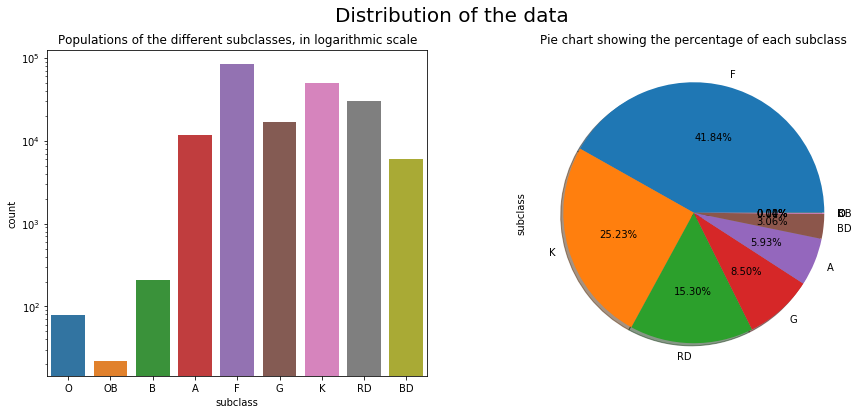

The exact populations are:


F     83072
K     50093
RD    30372
G     16872
A     11773
BD     6072
B       206
O        79
OB       22
Name: subclass, dtype: int64

In [10]:
fig, ax = plt.subplots(1,2, figsize=(15,6)) 
fig.suptitle('Distribution of the data', fontsize=20)

ax[0]=sns.countplot(x=stellar['subclass'], ax=ax[0])
ax[0].set_title('Populations of the different subclasses, in logarithmic scale')
ax[0].set_yscale('log')

ax[1]=stellar['subclass'].value_counts().plot.pie(y='subclass',autopct='%1.2f%%',shadow=True)
ax[1].set_title('Pie chart showing the percentage of each subclass')
plt.show()

print('The exact populations are:')
stellar['subclass'].value_counts()

<hr style="border:1px solid gray">

As seen above, the OB subtype is the least populated, containing only around 20 entries. This comes with no surprise, since the massive and hot stars of the main sequence burn their fuel quickly and are led to their death within a timescale of 1-10 million years, compared to the coldest stars that spend $\sim$ 10 billion years in the main sequence. Hot stars are hence intrinsically more rare and underrepresented, and for that reason they will be left out of the classification process. O and B subclasses are also underrepresented with length between a few decades and a few hundreds, while all the remaining subclasses are populated with at least 6 thousand stars. 


### To avoid an imbalanced training, we will neglect the O, OB, B subclasses
<hr style="border:1px solid gray">


### Data inspection and cleaning
<hr style="border:1px solid gray">

Inspect the min, max values of the features (u,g,r,i,z, W1,W2,W3,W4 magnitudes, parallax and proper motion). Drop the non-existing (NaN) observations or those with extremely low or extremely high values, that could correspond to either bad, or absernt measurements.
<hr style="border:1px solid gray">


In [11]:
stellar.describe()

,ra,dec,u,g,r,i,z,W1mag,W2mag,W3mag,W4mag,y,j,h,k,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,pm_error,pm_over_error,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag
count,198561.000000,198561.000000,198561.000000,198561.000000,198561.000000,198561.000000,198561.000000,198561.000000,198559.000000,198306.000000,198517.000000,173102.000000,178734.000000,177584.000000,179389.000000,195136.000000,195136.000000,195136.000000,195136.000000,195136.000000,195136.000000,195136.000000,195136.000000,198561.000000,195136.000000,198515.000000,195581.000000,195647.000000
mean,148.413750,6.866605,19.996766,18.321517,17.570950,17.157642,16.934663,15.279247,15.264213,12.347086,8.835422,16.297858,15.970738,15.512997,15.397349,0.886956,0.159087,9.235136,14.273194,-0.340335,0.177891,-7.819483,0.144377,0.226469,110.987600,17.511727,18.059108,16.799376
std,108.879236,9.492567,2.092014,1.697450,1.444109,1.223965,1.159380,1.223565,1.203546,0.354065,0.305259,1.172772,1.195493,1.190366,1.202593,1.440964,0.160992,19.218221,15.710035,15.197353,0.185438,12.582140,0.155403,0.240467,182.096140,1.308547,1.493214,1.211869
min,0.002795,-3.727407,10.611810,9.300097,8.814259,8.142487,8.406283,5.107000,5.045000,1.675000,-1.614000,10.442000,10.026000,10.380000,9.857000,-12.814800,0.009400,-14.237400,0.008000,-172.848000,0.007000,-171.196000,0.010000,0.000000,0.019406,8.741797,9.135576,7.714036
25%,37.522773,0.054906,18.505370,17.154350,16.591100,16.310960,16.126830,14.442000,14.436000,12.151000,8.662000,15.487000,15.146000,14.682000,14.564000,0.224575,0.067100,1.643475,5.271000,-5.368000,0.073000,-10.597000,0.058000,0.091831,26.215257,16.619418,17.020340,15.964323
50%,152.869684,1.751538,19.619830,18.165510,17.514230,17.187360,16.993340,15.309000,15.315000,12.394000,8.863000,16.357000,16.010000,15.555000,15.428000,0.479700,0.110200,4.322300,9.483000,-0.578000,0.121000,-5.221000,0.097000,0.154467,56.535970,17.515457,17.993864,16.844513
75%,211.176485,10.065636,21.220930,19.211420,18.456300,18.053460,17.798360,16.186000,16.239000,12.559000,9.022000,17.162000,16.834000,16.398000,16.291000,0.978200,0.190800,10.269825,17.100000,4.492250,0.213000,-1.757000,0.173000,0.272958,123.584884,18.415874,18.975145,17.695935
max,359.996996,36.200200,29.989850,24.988640,30.062340,28.588230,30.723860,18.356000,17.864000,13.440000,9.845000,20.778000,23.484000,19.681000,18.889000,42.933700,3.955200,1358.645800,190.408000,173.440000,3.086000,146.958000,2.902000,4.096983,9069.096102,21.873493,24.237211,21.357464


In [15]:
print(stellar.isnull().sum())
print('Total: there are', len(stellar['ra']), 'stars after drop duplicates')

Total: there are 198561 stars after drop duplicates


Many empty cells are spotted, especially for the infrared y,j,k,h magnitudes. We drop all these rows with empty cells.

In [16]:
def dropnan():
    nan_value = float("NaN")
    stellar.replace("", nan_value, inplace=True)
    features = stellar[['u','g','r','i','z','y','j','h','k','W1mag','W2mag','W3mag','W4mag', 
                       'parallax','parallax_over_error', 'pm', 'pm_over_error' ]]

    for i in features.columns:
        stellar.dropna(subset = [i], inplace=True)

In [19]:
dropnan()
print(stellar.isnull().sum())
print('Total there are:', len(stellar['ra']), 'stars after drop duplicates')

ra                        0
dec                       0
u                         0
g                         0
r                         0
i                         0
z                         0
subClass                  0
W1mag                     0
W2mag                     0
W3mag                     0
W4mag                     0
y                         0
j                         0
h                         0
k                         0
parallax                  0
parallax_error            0
parallax_over_error       0
pm                        0
pmra                      0
pmra_error                0
pmdec                     0
pmdec_error               0
pm_error                  0
pm_over_error             0
phot_g_mean_mag          20
phot_bp_mean_mag       1039
phot_rp_mean_mag       1024
subclass                  0
dtype: int64
Total there are: 147470 stars after drop duplicates


<hr style="border:1px solid gray">

### Fix the ranges of the features of the training to reasonable values (based on th stellar.describe values), so that bad measurements that may affect the classification are dropped.
<hr style="border:1px solid gray">


In [21]:
def magnitudes_range():
    magnitudes = stellar[['u','g','r','i','z','y','j','h','k','W1mag','W2mag','W3mag','W4mag']]
    for i in magnitudes:
        index = stellar[(stellar[i] >= 25)|(stellar[i] <= 5)].index
        stellar.drop(index, inplace=True)

In [25]:
def plot_magnitudes():
    fig = plt.figure(figsize = (17, 16))
    plt.style.use('dark_background')
    
    fig.patch.set_facecolor('xkcd:black')
    x = [*range(1, 14, 1)]
    magnitudes = stellar[['u','g','r','i','z','y','j','h','k','W1mag','W2mag','W3mag','W4mag']]

    for k, n in zip(x, magnitudes.columns):
            ax=plt.subplot(3,5,k)
            sns.boxplot(x='subclass',y=n,data=stellar)
            ax.set_title(n, fontweight = 'bold', fontsize = 16)

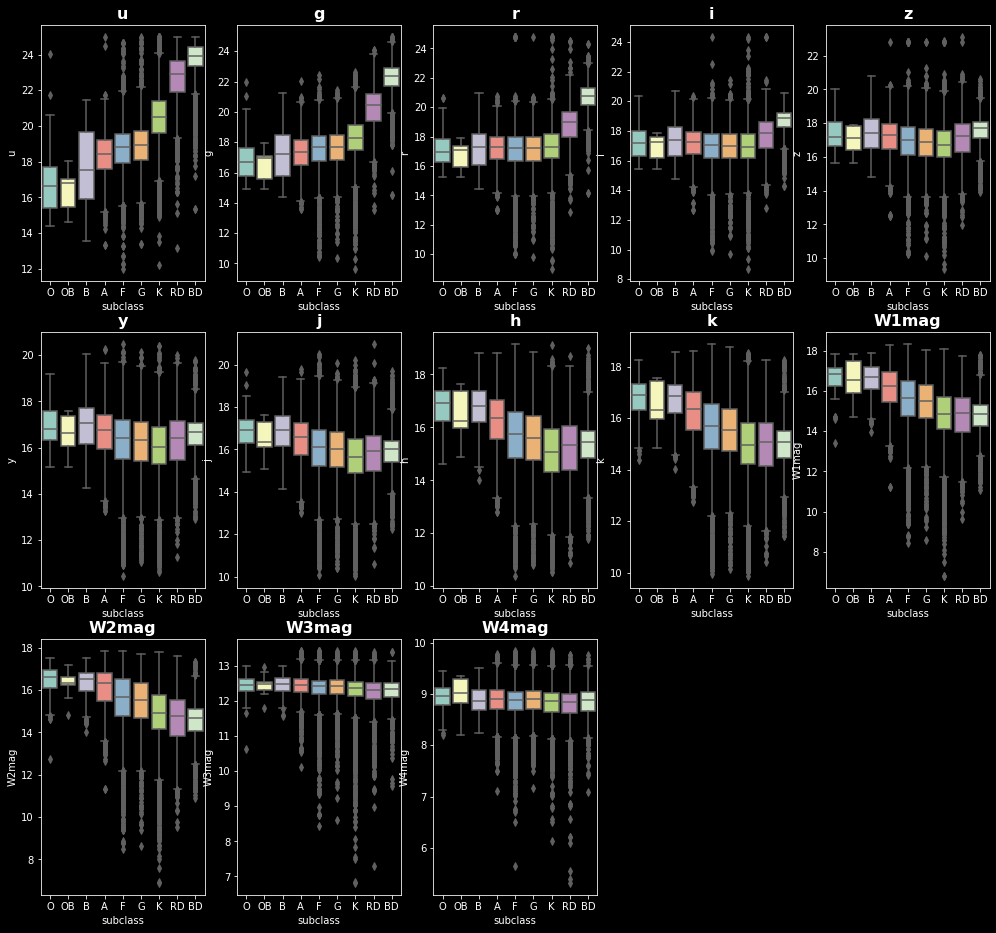

In [26]:
magnitudes_range()
plot_magnitudes()

In [29]:
def colour_colour_plot(x,y,z,w):
    plt.figure(figsize = (25,15))
    plt.title('Stellar subclasses colour colour plot', fontsize = 45)
    plt.scatter(O[x] -O[y], O[z] - O[w], s = 70, marker = '*', label = "O stars")
    plt.scatter(OB[x] -OB[y], OB[z] - OB[w], s = 50, marker = '*', color ='mediumorchid',label = "OB stars")
    plt.scatter(B[x] -B[y], B[z] - B[w], s = 50, marker = '*', label = "B stars",color='lightseagreen')
    plt.scatter(A[x] -A[y], A[z] - A[w], s = 10, marker = '*', label = "A stars",color='cadetblue')
    plt.scatter(F[x] -F[y], F[z] - F[w], s = 10, marker = '*', label = "F stars",color='forestgreen', alpha = 0.5)
    plt.scatter(G[x] -G[y], G[z] - G[w], s = 10, marker = '*', label = "G stars", color = 'y', alpha = 0.8)
    plt.scatter(K[x] -K[y], K[z] - K[w], s = 10, marker = '*', label = "K stars",color='darkorange', alpha = 0.5)
    plt.scatter(red[x] -red[y],red[z] -red[w], s = 10, marker = '*', label = "Red_Dwarfs", color = 'crimson', alpha = 0.6)
    plt.scatter(brown[x] -brown[y], brown[z] - brown[w], s = 20, marker = '*', label = "Brown_Dwarfs", color = 'saddlebrown', alpha = 0.6)

    plt.xlabel(f"{x}-{y}", fontsize=30)
    plt.ylabel(f"{z}-{w}", fontsize=30)
    plt.xlim(-1,5)                  ## the xlim and ylim may need to be manually 
    plt.ylim(-1,5)                  ## adjusted in different choice of axes 
    plt.tight_layout()
    plt.legend(markerscale = 5, prop = {"size":25});
    print('Color color plot for all the stellar classes, showing the distribution of the stars from the bluest (O, OB, B located at the lower left corner) to the reddest (red and brown dwarfs, at the upper right corner)')

Color color plot for all the stellar classes, showing the distribution of the stars from the bluest (O, OB, B located at the lower left corner) to the reddest (red and brown dwarfs, at the upper right corner)


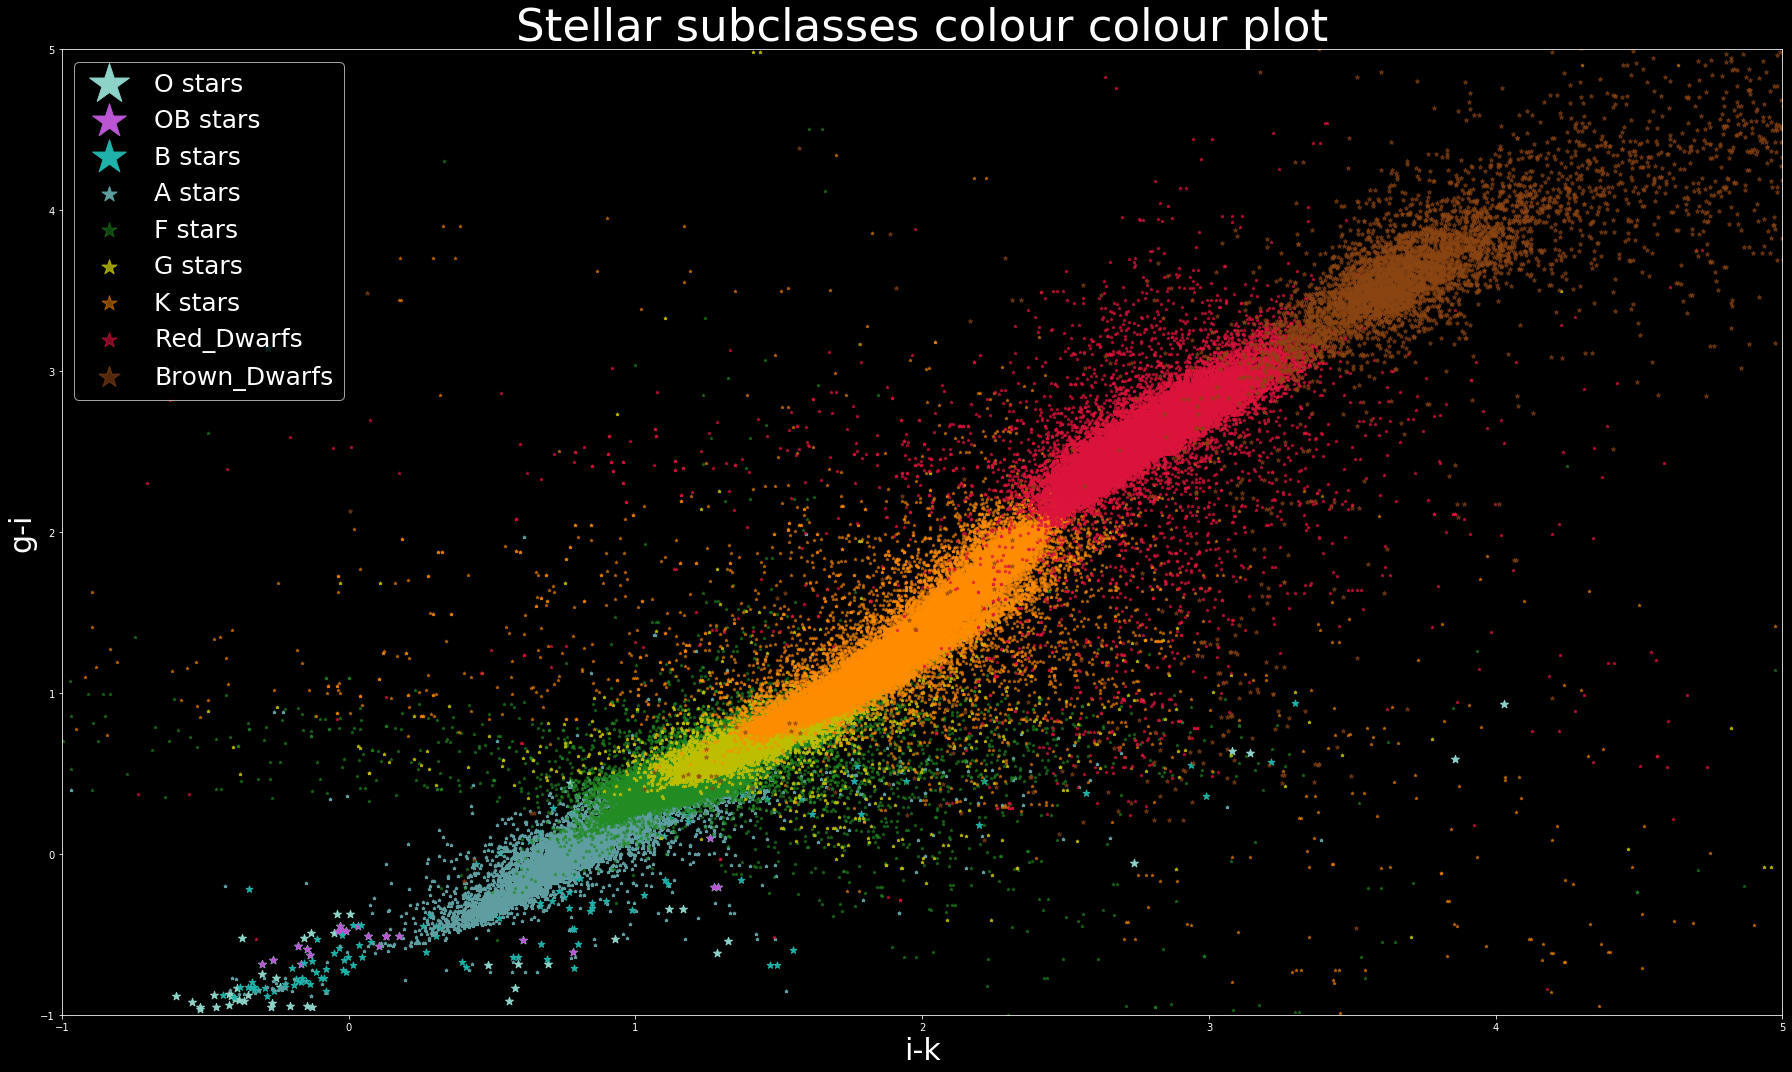

In [30]:
colour_colour_plot('i','k','g','i')

# Photometric + Astrometric machine learning for different stellar types

Assign truth values to each of the classes involved in the training

In [32]:
stellar['truth'] = [0 if x=='A'else 1 if x=='F' else 2 if x=='G' else 3 if x=='K' 
                    else 4 if x=='RD' else 5 for x in stellar['subclass']]

..and drop the O-OB-B subclasses as significantly underrepresented

In [33]:
stellar.drop(stellar[stellar['subclass'] =='O'].index, inplace=True)
stellar.drop(stellar[stellar['subclass'] =='OB'].index, inplace=True)
stellar.drop(stellar[stellar['subclass'] =='B'].index, inplace=True)

### Feature engineering
<hr style="border:1px solid gray">

It is found that different stellar subclasses, or different astronomical sources in nature(eg. stars, galaxies, quasars) form clusters and are well separated in colour-colour plots, such as the gi-iK shown above. By definition, the colours are the differences between two given magnitudes, and this is what we do in the following chunk of code. 

There are physical arguments behind this choice of feature addition. In the case of a star and a quasar for example, we know that the stellar spectrum follows a black body distribution, while the quasar spectrum follows a power law. So even if the photometry of the one source resembles that of the other, there still are specific colours that can occur different. Traditionally, this method has been a selection technique for identifying quasars, as the typical quasars demonstrate a U-V excess. There are more colour criteria that cover the cases of reddened quasars, such as the infrared excess (high J-K colour values). Such photometric criteria can also be applied in the case of stellar subclasses, since due to their different temperatures the black body's curve maximum is shifted according to the Wien's law. Also, different temperatures cause different atomic excitations in the star's atmosphere, which translates into absorption lines in different wavelengths and thus distinctive values when pairs of magnitudes are subtracted. As a result, they also appear to gradually 'climb' the (gi-iK) colour colour plot with some separation, the F and G stars being an exception to the rule by showing the highest degree of overlapping.

Here, we allow such empirical cut-offs to enter the classification process as features of the training.
<hr style="border:1px solid gray">


In [34]:
stellar["ug"]= stellar["u"]-stellar["g"]
stellar["ur"]= stellar["u"]-stellar["r"]
stellar["ui"]= stellar["u"]-stellar["i"]
stellar["uz"]= stellar["u"]-stellar["z"]
stellar["gr"]= stellar["g"]-stellar["r"]
stellar["gi"]= stellar["g"]-stellar["i"]
stellar["gz"]= stellar["g"]-stellar["z"]
stellar["ri"]= stellar["r"]-stellar["i"]
stellar["rz"]= stellar["r"]-stellar["z"]
stellar["iz"]= stellar["i"]-stellar["z"]
stellar["W1W2"]= stellar["W1mag"]-stellar["W2mag"]
stellar["W1W3"]= stellar["W1mag"]-stellar["W3mag"]
stellar["W1W4"]= stellar["W1mag"]-stellar["W4mag"]
stellar["W2W3"]= stellar["W2mag"]-stellar["W3mag"]
stellar["W2W4"]= stellar["W2mag"]-stellar["W4mag"]
stellar["W3W4"]= stellar["W3mag"]-stellar["W4mag"]
stellar["YJ"]= stellar["y"]-stellar["j"]
stellar["YH"]= stellar["y"]-stellar["h"]
stellar["YK"]= stellar["y"]-stellar["k"]
stellar["JH"]= stellar["j"]-stellar["h"]
stellar["JK"]= stellar["j"]-stellar["k"]
stellar["HK"]= stellar["h"]-stellar["k"]
stellar["iK"]= stellar["i"]-stellar["k"]

### Train the model
<hr style="border:1px solid gray">

We run the classification using the XGBoost algorithm, after setting the parameters to 

$objective='multiclass:softmax'$ and 

$num class = 6$. 

Both astrometric and photometric measurements are used as features of the training, with the photometry ranging from the optical to the mid-IR bands.
<hr style="border:1px solid gray">


In [37]:
X=stellar[['u', 'g', 'r', 'i', 'z', 'W1mag', 'W2mag', 'W3mag', 'W4mag', 'y','j',
       'h', 'k','parallax', 'parallax_over_error', 'pm','pm_over_error' ,'ug', 'ur','ui','uz','gr', 'gi','gz',
          'ri', 'rz','iz',
          'YJ','YH','YK', 'JH', 'JK', 'HK', 'iK','W1W2', 'W1W3', 'W1W4', 'W2W3', 'W2W4', 'W3W4']]  # Features
y=stellar[ 'truth']  # Labels
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)
model_xgboost = xgb.XGBClassifier(objective='multiclass:softmax',num_class = 6, learning_rate=0.1,
                            max_depth=10, eval_metric='mlogloss', n_estimators=300,
                            seed=42, use_label_encoder=False)
model_xgboost.fit(x_train,y_train)
ypred_xgboost=model_xgboost.predict(x_test) 
accuracy_xgb = accuracy_score(y_test,ypred_xgboost)  

### Save the model

In [38]:
filename='model_stellar_subclass.sav'
pickle.dump(model_xgboost,open(filename,'wb'))

### Evaluation metrics 
<hr style="border:1px solid gray">
In this section we will describe the statistical metrics used to evaluate the performance of a machine learning algorithm. In order to make the definitions stand out clearly, let us first describe our statistical ensemble of the input data. Let us consider the 2 class problem; each data point is either a positive, or a negative one. The trained model will make predictions and will assign a class to every data point. All the possible outcomes are four: it can be a TP (true positive),  a TN (true negative), a FP (false positive), or a FN (false negative). Only in the first two cases, has the program identified correctly the class of the given object. Through these labels we can define the basic statistical metrics, namely the accuracy, recall, precision, and f1-score, that all take values between 0 and 1. The situation is natirally extended in the case of a multiclass classification.
<hr style="border:1px solid gray">


# Classification report
<hr style="border:1px solid gray">

The most common and well-known metric is the accuracy, defined as the ratio between all the successful predictions of the model, to the total number of the entries:

### Accuracy = (TP + TN)/ (TP+FP+TN+FN)

Despite its usefulness in balanced classification problems, accuracy can be a misleading metric, especially in cases of a highly imbalanced training set or a multiclass classification problem. For example, in an ensemble of 100 objects where 97 of them are positive and the model predicts all of the 100 as positive, it is clear that it totally fails to identify the negative cases, while it still hits an accuracy of 97\%. This dictates the introduction and use of quantities that can measure the loss of information for each of the classes involved in the training, such as the ones that follow:

Recall is the ratio of the successful positive predictions, to the total number of positive entries. This metric is referred to as completeness.

### Recall = TP/(TP+FN)     (completeness)

In probabilistic terms, recall answers the question 'how probable is to pick a true positive out of the actual positives ensemble'. Based on that definition, recall is also referred to as sensitivity, or true positive rate (TPR). It is related to the false negative rate (FNR) as  TPR + FNR =1 . Simirarly, the true negative rate (TNR), or else specificity, is expressed by the fraction:

### True Negative Rate = (TN)(TN+FP)

Precision refers to the ratio of the successful identifications, to the total number of positive predictions, those not identified correctly included. This ratio is also known as purity. 

### Precision = (TP)(TP+FP)     (purity)

In other words, precision attempts to answer the question 'what proportion of the positive predictions is actually correct'.

Lastly, the F1-score metric is a combination of recall and precision, as the harmonic mean of the two:

### F1_ score = 2*(Recall *Precision)(Recall +Precision) = 2TP)(2TP + FP +FN)


<img src="recall.png"  width="600" height="500">
<hr style="border:1px solid gray">


### Confusion matrix

<hr style="border:1px solid gray">
The situation becomes more clear through the confusion matrix: a visualization tool to express the performance of a model in assigning classes to objects. Here the contamination from objects of the mislabeled class is more obvious and different classification problems should focus more on different elements of the confusion matrix. For example, if one wants to identify as many objects of the 'positive' class as possible, he should construct a model that minimizes the false negatives and care less about the false positives. If so, it would mean that the positive class would surely be contaminated by negative objects, but there would be minimum loss of positive objects, mislabeled as negative. This situation describes well a classification problem that focuses on the outliers of a class, where one may attempt the best fitting classification of data into classes, but the main concern remains the true recognition of as many objects of a class as possible, even if their characteristics resemble that of another class. The closest to unity the diagonal elements of a confusion matrix are and the closest to zero the non-diagonal elements are, the better the metrics of the model will occur.

<img src="confusion.png"  width="600" height="500">
<hr style="border:1px solid gray">


In [93]:
def report():
    from colorama import Back, Fore, Style
    print(Fore.RED+'The accuracy on the test set is:',Style.RESET_ALL,"{:.2f}".format(accuracy_xgb)) 
    confusion_matrix = pd.crosstab(y_test, ypred_xgboost, rownames=['Actual Subclass'], colnames=['Predicted Subclass'])
    print()
    print(Fore.RED+'Classification Report:', Style.RESET_ALL)
    print(metrics.classification_report(y_test,ypred_xgboost, digits=3))
    print(Fore.RED+'Confusion Matrix:', Style.RESET_ALL)
    plt.figure(figsize=(10,8))
    sns.heatmap(confusion_matrix, annot=True, cmap='cividis')
    plt.show();

The accuracy on the test set is:  0.89

Classification Report: 
              precision    recall  f1-score   support

           0      0.884     0.694     0.777      2399
           1      0.852     0.940     0.894     16477
           2      0.726     0.471     0.572      3173
           3      0.962     0.955     0.959      8968
           4      0.987     0.991     0.989      4413
           5      0.972     0.936     0.954       817

    accuracy                          0.893     36247
   macro avg      0.897     0.831     0.857     36247
weighted avg      0.890     0.893     0.887     36247

Confusion Matrix: 


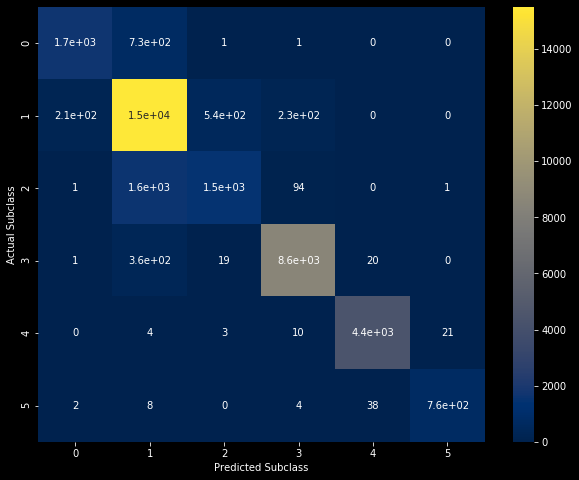

In [94]:
report()

<hr style="border:1px solid gray">
Confusion matrix of the multiclass classification. Rows and columns labeled with the numbers 0-3 correspond to stellar subclasses A to K respectively, number 4 refers to the red dwarfs and 5 to the brown dwarfs. Subclasses A-K  are the problematic ones, seeming to be mixed up with their neighbouring subclasses. On the other hand, the model seems to well separate the red and brown dwafs from the rest objects.

The overall accuracy is pretty low, ~90%, but this is due to the mixing up between the F and G subclasses. Even in a color color plot, these two subclasses appear to be overlapping and we assume this is the reason behind the confusion.
<hr style="border:1px solid gray">


## Feature Importance

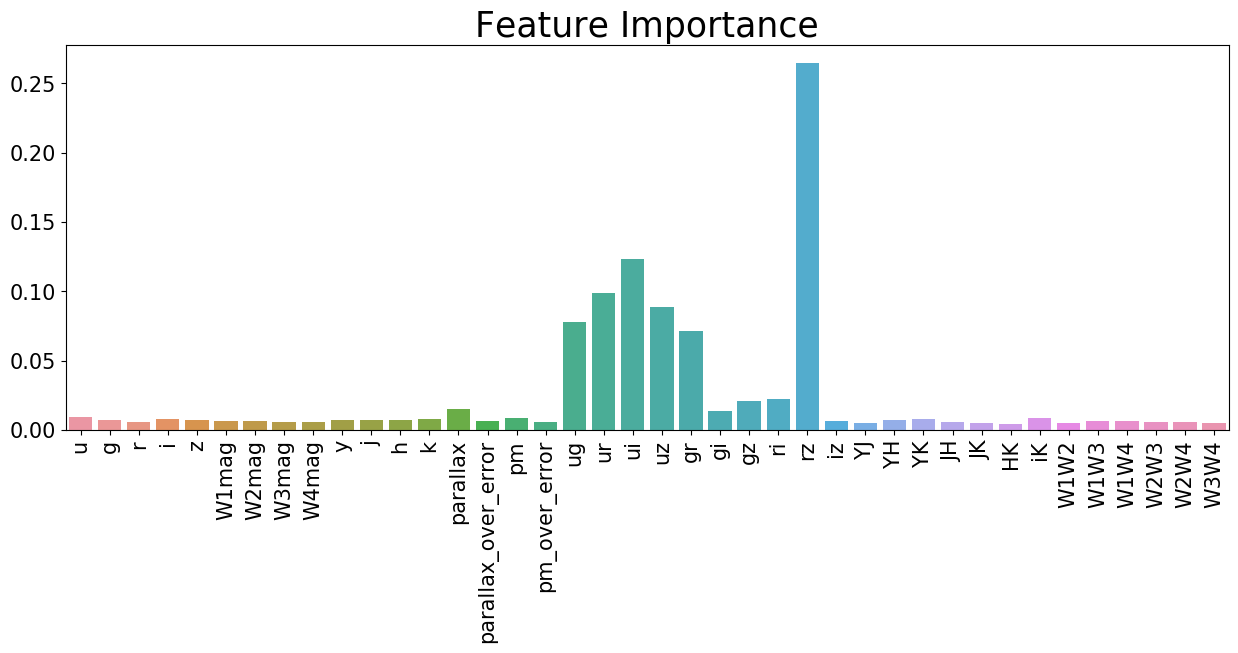

In [184]:
features = ['u', 'g', 'r', 'i', 'z', 'W1mag', 'W2mag', 'W3mag', 'W4mag', 'y','j',
            'h', 'k','parallax', 'parallax_over_error', 'pm','pm_over_error' ,'ug', 'ur',
            'ui','uz','gr', 'gi','gz','ri', 'rz','iz','YJ','YH','YK', 'JH', 'JK', 'HK', 
            'iK','W1W2', 'W1W3', 'W1W4', 'W2W3', 'W2W4', 'W3W4'] 
plt.style.use('default')

plt.figure(figsize = (15,5))
plot = sns.barplot(x=features, y=model_xgboost.feature_importances_)
plt.title('Feature Importance',fontsize=25)
plot.set_xticklabels(plot.get_xticklabels(),rotation='vertical')
ax=plt.axes()
ax.tick_params(axis="x",colors="k",labelsize=15)
ax.tick_params(axis="y",colors="k",labelsize=15)
plt.show();

<hr style="border:1px solid gray">

#### The feature importance plot reflects the fact that the colours are actually more crucial for the classification between different stellar subclasses than the magnitudes.
<hr style="border:1px solid gray">


### Visualize the results:

Misclassified stars are also shown in the following colour-colour plot

In [210]:
def plot_misclassified(x,y,z,w):    
    fig = plt.figure(figsize = (13,9))

    plt.title('Stellar subclasses color color plot', fontsize = 40)
    arrange = [*range(0, 6, 1)]
    labels = ['A star','F star','G star','K star','Red Dwarf','Brown Dwarf']

    for k in (arrange):
        plt.scatter(stellar[x][stellar['truth']==k]-stellar[y][stellar['truth']==k], 
                stellar[z][stellar['truth'] ==k]-stellar[w][stellar['truth'] ==k], 
                s = 25, marker = '*', label = labels[k], edgecolor = 'k', linewidth = 0.06, alpha=0.7)
        ax = plt.axes() 
        ax.tick_params(axis='x', colors='k', labelsize=15)
        ax.tick_params(axis='y', colors='k', labelsize=15)
        ax.set_xlabel(f"{x} - {y}", fontsize = 20,fontweight = 'bold')
        ax.set_ylabel(f"{z} - {w}", fontsize = 20 , fontweight = 'bold') 

        plt.xlim(-0.3,1.5)
        plt.ylim(-1.3,1.5)
        plt.tight_layout()
        plt.legend(markerscale = 2, prop = {"size":20});
    plt.scatter(x_test[x][y_test !=ypred_xgboost]-x_test[y][y_test !=ypred_xgboost], 
                x_test[z][y_test !=ypred_xgboost]-x_test[w][y_test !=ypred_xgboost], s = 7,alpha = 1, 
                edgecolor = 'k', facecolor = 'grey', label = 'misclassified')
    plt.legend(markerscale = 2, prop = {"size":20});

    plt.show();

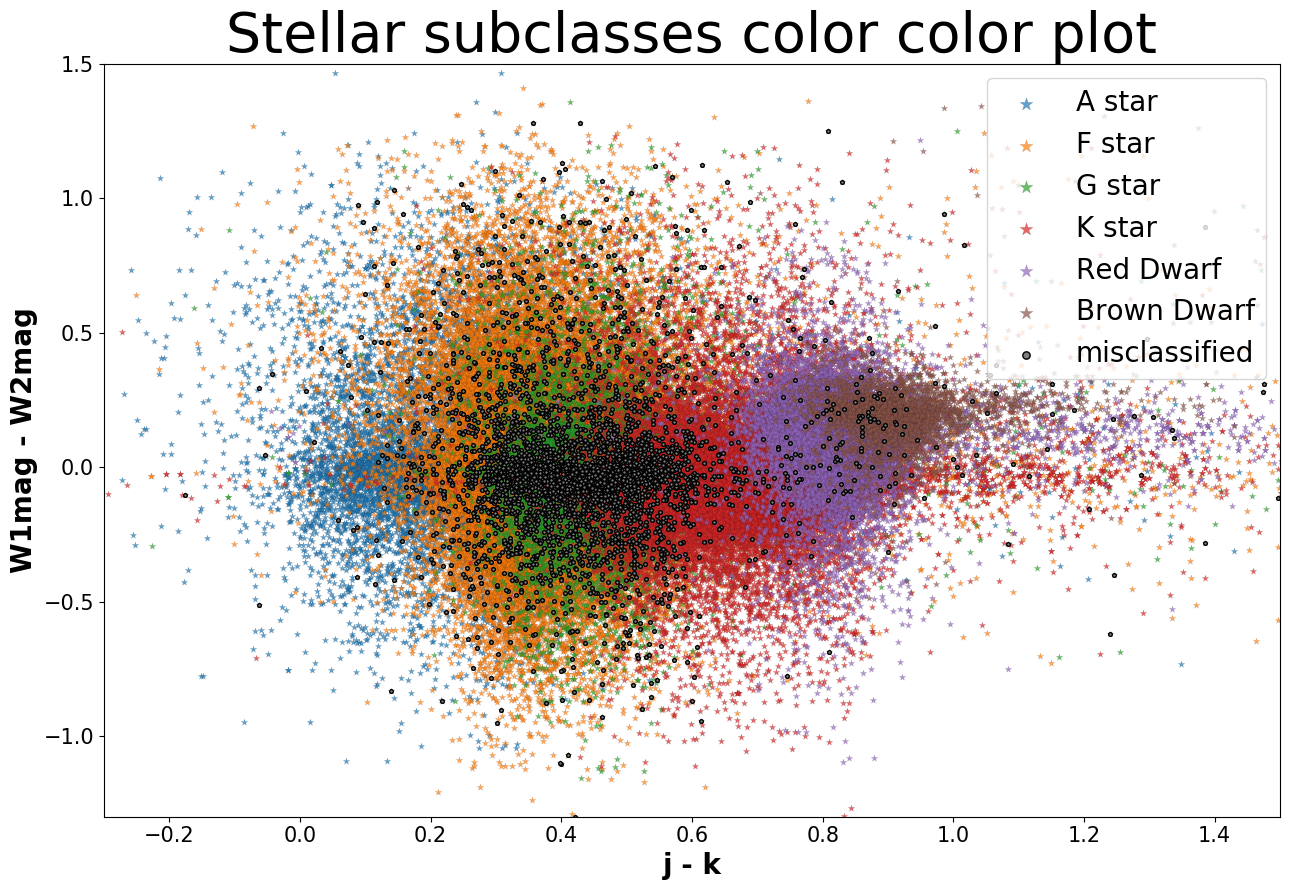

In [211]:
plot_misclassified('j','k','W1mag','W2mag')

<hr style="border:1px solid gray">
Colour colour plot where the stellar subclasses are denoted in different colors. A clear overlap between the G class  and its neighbouring F and K is the cause of the model's bad performance in distinguishing those classes. Most of the misclassified objects fall on this part of the JK-W1W2 plot.
<hr style="border:1px solid gray">
